In [1]:
import pandas as pd
import numpy as np
import regex as re
import string
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer, StandardScaler, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline


# Data Loading:

In [2]:
movies_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
train_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

In [3]:
train_df.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [4]:
movies_df.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [5]:
test_df.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [6]:
print(movies_df.describe())
print(train_df.describe())

       audienceScore  runtimeMinutes
count   73248.000000   129431.000000
mean       55.674967       93.708578
std        24.553648       28.129175
min         0.000000        1.000000
25%        37.000000       84.000000
50%        57.000000       92.000000
75%        76.000000      103.000000
max       100.000000     2700.000000
                                            movieid     reviewerName  \
count                                        162758           162758   
unique                                        16812             4482   
top     escape_the_terminator_tyler_durden_astonish  Sherri Morrison   
freq                                            708              962   

       isFrequentReviewer               reviewText sentiment  
count              162758                   156311    162758  
unique                  2                   155071         2  
top                 False  Parental Content Review  POSITIVE  
freq               113189                       29    

In [7]:
count=CountVectorizer()

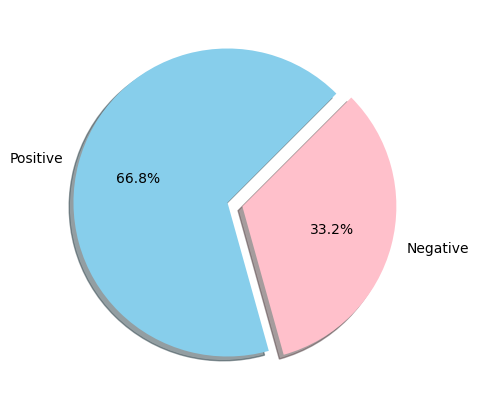

In [8]:
fig=plt.figure(figsize=(5,5))
colors=["skyblue",'pink']
pos=train_df[train_df['sentiment']=='POSITIVE']
neg=train_df[train_df['sentiment']=='NEGATIVE']
ck=[pos['sentiment'].count(),neg['sentiment'].count()]
legpie=plt.pie(ck,labels=["Positive","Negative"],
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

In [9]:
movies_df.drop_duplicates(subset='movieid', inplace=True)
train_df.drop_duplicates(subset=['movieid', 'reviewerName', 'reviewText'], inplace=True)

In [10]:
train_df.dropna(subset='reviewText', inplace=True)
train_df.reset_index(drop=True, inplace=True)

In [11]:
movies_df.reset_index(drop=True, inplace=True)

# Merge Metadata:

In [12]:
data = pd.merge(train_df, movies_df, on='movieid', how='left') 
test_df = pd.merge(test_df, movies_df, on='movieid', how='left')

In [13]:
tgt = data['sentiment']
data = data[[ 'reviewText', 'rating', 'genre', 'ratingContents', 'audienceScore', 'distributor','boxOffice','releaseDateStreaming', 'releaseDateTheaters','director', 'soundType', 'runtimeMinutes', 'originalLanguage']]

In [14]:
import pandas as pd
from scipy.stats import chi2_contingency

categorical_columns = ['rating', 'genre', 'ratingContents', 'audienceScore', 'distributor','boxOffice','releaseDateStreaming', 'releaseDateTheaters','director', 'soundType', 'runtimeMinutes', 'originalLanguage']
results = []

for col in categorical_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(data[col],tgt)
    
    # Perform the Chi-squared test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    
    results.append({
        'Column': col,
        'Chi-squared': chi2_stat,
        'P-value': p_val
    })

results_df = pd.DataFrame(results)
print(results_df)
 

                  Column   Chi-squared        P-value
0                 rating    476.523185  9.572574e-100
1                  genre  11135.011390   0.000000e+00
2         ratingContents  24670.117810   0.000000e+00
3          audienceScore  14682.535457   0.000000e+00
4            distributor  10173.655346   0.000000e+00
5              boxOffice  17408.843160   0.000000e+00
6   releaseDateStreaming  13402.846866   0.000000e+00
7    releaseDateTheaters  17004.542488   0.000000e+00
8               director  36423.375288   0.000000e+00
9              soundType   3970.809972   0.000000e+00
10        runtimeMinutes   1667.807629  8.410127e-223
11      originalLanguage   2022.574197   0.000000e+00


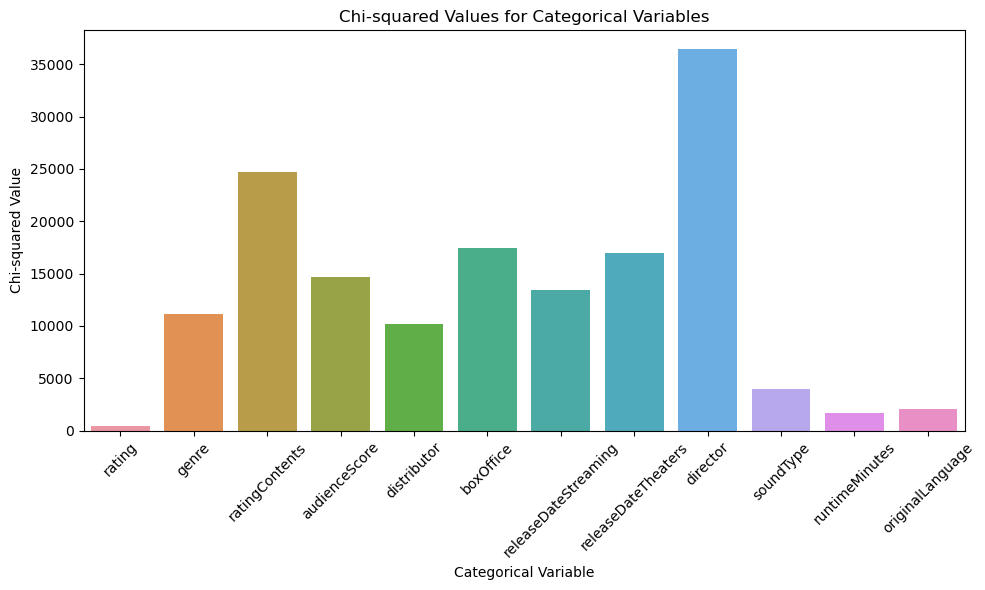

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Column', y='Chi-squared')
plt.xticks(rotation=45)
plt.xlabel('Categorical Variable')
plt.ylabel('Chi-squared Value')
plt.title('Chi-squared Values for Categorical Variables')
plt.tight_layout()
plt.show()

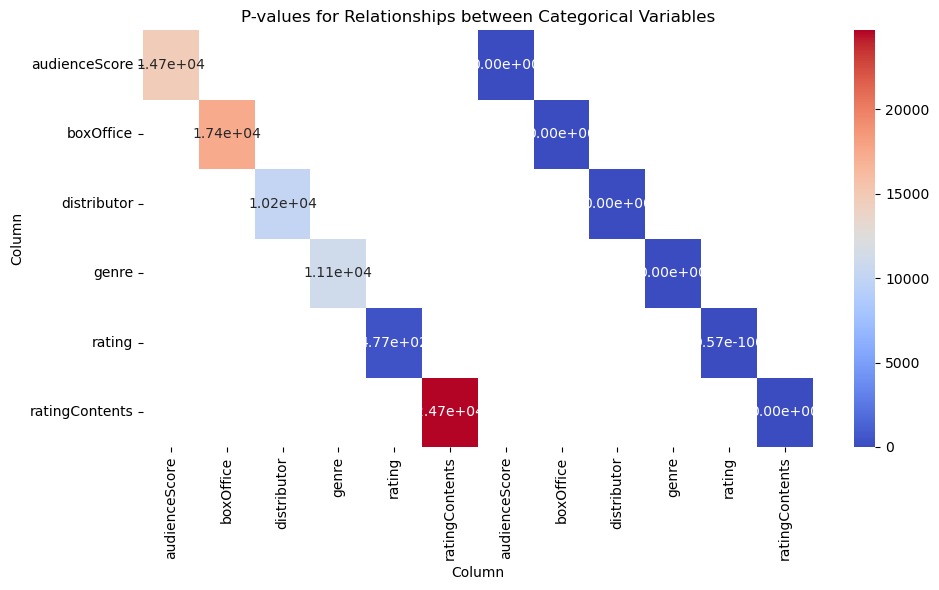

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for demonstration
df = {
    'Column': ['rating', 'genre', 'ratingContents', 'audienceScore', 'distributor', 'boxOffice'],
    'Chi-squared': [476.52, 11135.01, 24670.11, 14682.53, 10173.66, 17408.84],
    'P-value': [9.57e-100, 0.0, 0.0, 0.0, 0.0, 0.0]
}

results_df = pd.DataFrame(df)

# Create a heatmap for p-values
p_value_matrix = results_df.pivot_table(index='Column', columns='Column', values='P-value', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(p_value_matrix, annot=True, cmap='coolwarm', fmt=".2e")
plt.title('P-values for Relationships between Categorical Variables')
plt.tight_layout()
plt.show()



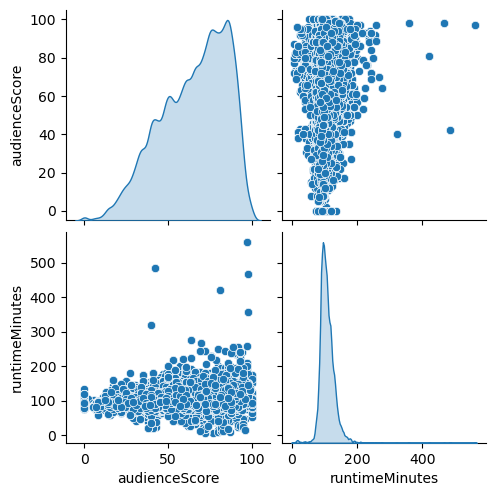

In [17]:
sns.pairplot(data, diag_kind='kde')
plt.show()

/tmp/ipykernel_20/301309501.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


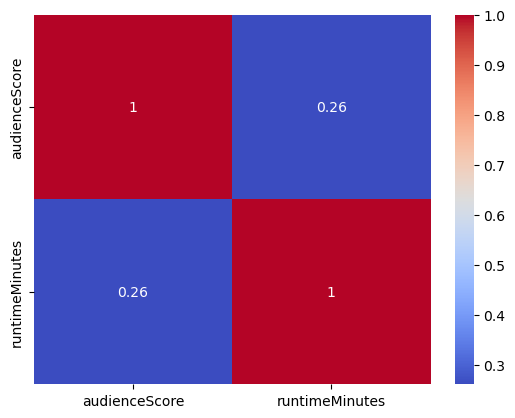

In [18]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

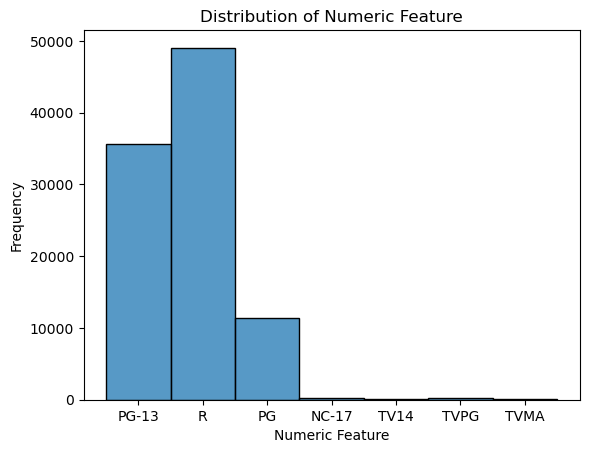

In [19]:
sns.histplot(data=data, x='rating', bins=20)
plt.xlabel('Numeric Feature')
plt.ylabel('Frequency')
plt.title('Distribution of Numeric Feature')
plt.show()


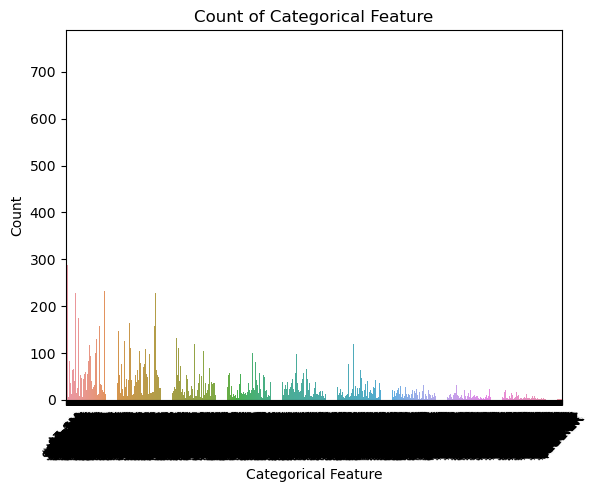

In [20]:
sns.countplot(data=data, x='boxOffice')
plt.xlabel('Categorical Feature')
plt.ylabel('Count')
plt.title('Count of Categorical Feature')
plt.xticks(rotation=45)
plt.show()


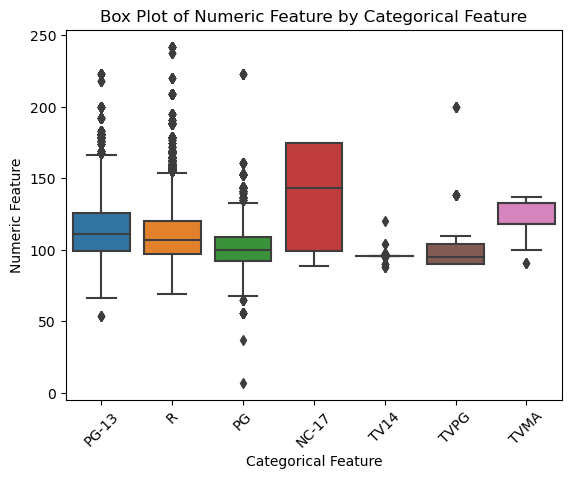

In [21]:
sns.boxplot(data=data, x='rating', y='runtimeMinutes')
plt.xlabel('Categorical Feature')
plt.ylabel('Numeric Feature')
plt.title('Box Plot of Numeric Feature by Categorical Feature')
plt.xticks(rotation=45)
plt.show()


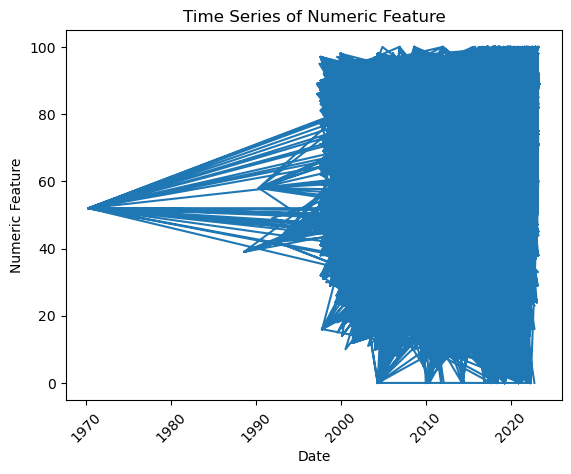

In [22]:
data_copy = data.copy()  


data_copy['releaseDateStreaming'] = pd.to_datetime(data_copy['releaseDateStreaming'])


data_copy.set_index('releaseDateStreaming', inplace=True)

# Plotting
plt.plot(data_copy.index, data_copy['audienceScore'])
plt.xlabel('Date')
plt.ylabel('Numeric Feature')
plt.title('Time Series of Numeric Feature')
plt.xticks(rotation=45)
plt.show()


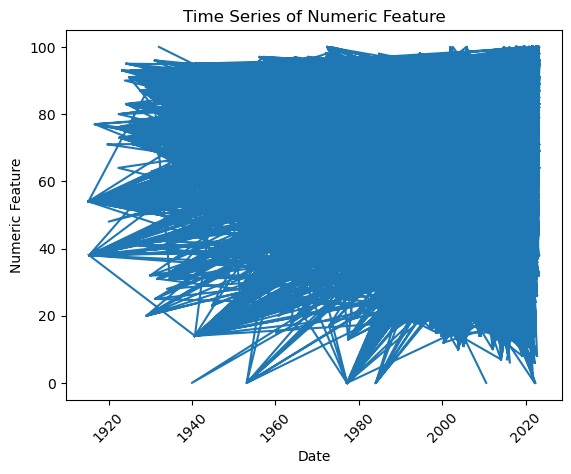

In [23]:

data_copy = data.copy() 


data_copy['releaseDateTheaters'] = pd.to_datetime(data_copy['releaseDateTheaters'])


data_copy.set_index('releaseDateTheaters', inplace=True)

# Plotting
plt.plot(data_copy.index, data_copy['audienceScore'])
plt.xlabel('Date')
plt.ylabel('Numeric Feature')
plt.title('Time Series of Numeric Feature')
plt.xticks(rotation=45)
plt.show()


In [24]:
test_df = test_df[[ 'reviewText', 'rating', 'genre', 'ratingContents', 'audienceScore', 'distributor','boxOffice','releaseDateStreaming', 'releaseDateTheaters','director', 'soundType', 'runtimeMinutes', 'originalLanguage']]

In [25]:
lb = LabelBinarizer()
tgt = lb.fit_transform(tgt)
tgt = tgt.ravel()


In [26]:
class TextProcessor(BaseEstimator, TransformerMixin):
    stop_words = set(ENGLISH_STOP_WORDS)
    stop_words.update(['film', 'films', 'movie', 'movies', 'director', 'plot', 'story', 'actor', 'actors', 'cast',
                       'scene', 'scenes', 'cinema', 'hollywood', 'script', 'screenplay', 'character', 'charaters', 'role',
                       'roles', 'actress', 'actresses', 'genre', 'genres', 'sequel', 'prequel', 'remake', 'remakes', 'original',
                       'version', 'versions', 'franchise', 'franchises', 'cinematography', 'cinematographer', 'cinematographers',
                       'cinematographic', 'cinematographics', 'cinematic', 'cinematics', 'cinematograph', 'cinematographs', 
                       'cinematographical', 'cinematographically', 'like', 'just', 'review', 'reviews', 'storyline', 'storylines',
                       'story', 'stories', 'plotline', 'dont', 'didnt', 'doesnt', 'cant', 'couldnt', 'wouldnt', 'shouldnt', 'wont',
                       'just', 'isnt', 'arent', 'wasnt', 'werent', 'havent', 'hasnt', 'hadnt', 'having', 'got', 'get',
                       'gets', 'gotten', 'im', 'ive', 'id', 'ill', 'youre', 'youve', 'youll', 'youd', 'theyre', 'theyve',
                       'theyll', 'theyd', 'weve', 'wed', 'were', 'wasnt'
                      ])
    

    process_pattern = re.compile(r"\s|[.,?!;:-_]")
    whitespace_pattern = re.compile(r"\s+")
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: pd.Series, y=None, stem=False):
        X = X.copy()
        X.fillna("", inplace=True)
        X = X.apply(self.process_text)
        return X
    
    def process_text(self, text):
        text = text.lower()

        words_without_apostrophe = []
        for word in text.split():
            if "'" not in word:
                words_without_apostrophe.append(word)
        text = " ".join(words_without_apostrophe)

        text_characters = []
        for character in text:
            if character.isalpha() or character.isspace():
                text_characters.append(character)
        text = "".join(text_characters)

        words = []
        for word in text.split():
            if len(word) > 2 and word not in self.stop_words:
                words.append(word)
        text = " ".join(words)

        whitespace_removed = []
        words = text.split()
        for word in words:
            if word:
                whitespace_removed.append(word)
        text = " ".join(whitespace_removed)

        return text




In [27]:
class DirectorProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['director'] = X_copy['director'].str.split(', ')
        X_copy['director'] = X_copy['director'].apply(lambda x: '|'.join(map(str, x)) if isinstance(x, list) else x)
        return X_copy

In [28]:

class BoxOfficeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(str)
        return X.apply(self.convert_bo)
    
    def convert_bo(self, x):
        if isinstance(x, str):
            x = x.replace('$', '')
            x = x.replace(',', '')
            if x == 'R':
                x = x.replace('R', '')
                return float(x) 
            elif x.endswith('K'):
                x = x.replace('K', '')
                return float(x) * 1000
            elif x.endswith('M'):
                x = x.replace('M', '')
                return float(x) * 1000000
            elif x.endswith('B'):
                x = x.replace('B', '')  
                return float(x) * 1000000000
            else:
                return float(x)
            print(str)
        else:
            return np.nan

In [29]:
text_pipeline = Pipeline([
    ('text_processor', TextProcessor()),         
    ('tfidf_vectorizer', TfidfVectorizer(stop_words='english'))
])

In [30]:
text_cat_pipeline = Pipeline([
    ('text_processor', TextProcessor()),         
    ('count', CountVectorizer())    
])

In [31]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())   
])

In [32]:
box_office_pipeline = Pipeline([
    ('box_office_transformer', BoxOfficeTransformer()),
    ('reshape', FunctionTransformer(lambda x: x.values.reshape(-1,1), validate=False)),
    ('num', numeric_pipeline)
])

In [33]:
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('scaler', StandardScaler(with_mean=False)),
#     ('director_processor', DirectorProcessor()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))

])

In [34]:
preprocessor = ColumnTransformer([
    ('reviewText', text_pipeline, 'reviewText'),
    ('genre', text_cat_pipeline, 'genre'),
    ('ratingContents', text_cat_pipeline, 'ratingContents'),
    ('numeric', numeric_pipeline, ['audienceScore', 'runtimeMinutes']),
    ('boxoffice', box_office_pipeline, 'boxOffice'),
    ('categorical', categorical_pipeline, ['rating', 'director', 'distributor', 'releaseDateTheaters',  'releaseDateStreaming', 'soundType', 'originalLanguage']),
])

# Feature Engineering:

In [35]:
print(data.columns.tolist()) 

['reviewText', 'rating', 'genre', 'ratingContents', 'audienceScore', 'distributor', 'boxOffice', 'releaseDateStreaming', 'releaseDateTheaters', 'director', 'soundType', 'runtimeMinutes', 'originalLanguage']


In [36]:
X_train, X_test, y_train, y_test = train_test_split(data, tgt, test_size=0.2, shuffle=True, stratify=tgt, random_state=42)

In [37]:
# Performing oversampling on the training data
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [38]:
from sklearn.feature_selection import SelectKBest, SelectPercentile

skb = SelectKBest(k=1000)
k_percentile = SelectPercentile(percentile=25)
# k_percentile = SelectPercentile(score_func=mutual_info_classif, percentile=25)



In [39]:
from sklearn.feature_selection import SelectFromModel, mutual_info_classif

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
#     ('skb', skb),
    ('k_percentile', k_percentile),
#     ('feature_selector', SelectKBest(score_func=mutual_info_classif, k=10)),
#     ('feature_selector', feature_selector),
    ('logreg', LogisticRegression(max_iter=100000))
])

logreg_pipeline.fit(X_train, y_train)

accuracy = logreg_pipeline.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")



Accuracy: 0.82


In [40]:
# ensemble models
bagging_model = BaggingClassifier(base_estimator=logreg_pipeline['logreg'], n_estimators=10, random_state=42)
boosting_model = AdaBoostClassifier(base_estimator=logreg_pipeline['logreg'], n_estimators=50, random_state=42)

# final ensembled pipelines
bagging_pipeline = make_pipeline(logreg_pipeline['preprocessor'], bagging_model)
boosting_pipeline = make_pipeline(logreg_pipeline['preprocessor'], boosting_model)

# Fit and evaluate the bagging pipeline
bagging_pipeline.fit(X_train, y_train)
bagging_predictions = bagging_pipeline.predict(X_test)
bagging_accuracy = accuracy_score(y_test, bagging_predictions)
print(f'Bagging Accuracy: {bagging_accuracy:.2f}')

# Fit and evaluate the boosting pipeline
boosting_pipeline.fit(X_train, y_train)
boosting_predictions = boosting_pipeline.predict(X_test)
boosting_accuracy = accuracy_score(y_test, boosting_predictions)
print(f'Boosting Accuracy: {boosting_accuracy:.2f}')


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Accuracy: 0.82


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Boosting Accuracy: 0.71


In [41]:
# from sklearn.ensemble import GradientBoostingClassifier

# # Define the Gradient Boosting Classifier pipeline
# gb_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('k_percentile', k_percentile),  # If you're using feature selection
#     ('gb_classifier', GradientBoostingClassifier())
# ])

# # Fit the Gradient Boosting Classifier pipeline on the training data
# gb_pipeline.fit(X_train, y_train)

# # Predict sentiments on the test data
# predictions = gb_pipeline.predict(X_test)

# accuracy = gb_pipeline.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")

In [42]:
# cross-validation
cv_scores = cross_val_score(logreg_pipeline, X_train, y_train, cv=5, scoring='accuracy')

cv_scores
# cv_scores.mean()

array([0.81416321, 0.81520995, 0.81645799, 0.81693373, 0.81302842])

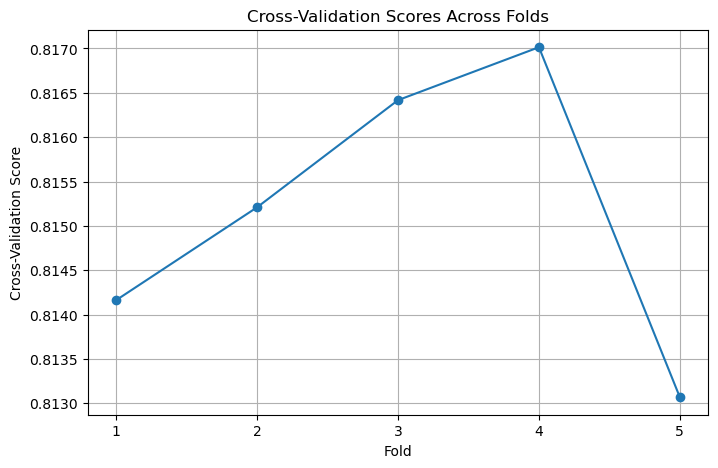

In [43]:
import matplotlib.pyplot as plt

cross_val_scores = [0.81416321, 0.81520995, 0.81641773, 0.81701425, 0.81306869]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cross_val_scores) + 1), cross_val_scores, marker='o')
plt.xlabel('Fold')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Scores Across Folds')
plt.xticks(range(1, len(cross_val_scores) + 1))
plt.grid(True)
plt.show()


In [44]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict 
predictions = logreg_pipeline.predict(X_test)

#classification report
class_labels = ["Negative", "Positive"]
classification_rep = classification_report(y_test, predictions, target_names=class_labels)
print("Classification Report:\n", classification_rep)

# AUC-ROC score
y_prob = logreg_pipeline.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob[:, 1]) 
print("AUC-ROC Score:", roc_auc)


Classification Report:
               precision    recall  f1-score   support

    Negative       0.77      0.64      0.70     10247
    Positive       0.84      0.91      0.87     20802

    accuracy                           0.82     31049
   macro avg       0.80      0.77      0.78     31049
weighted avg       0.81      0.82      0.81     31049

AUC-ROC Score: 0.8818029753071447


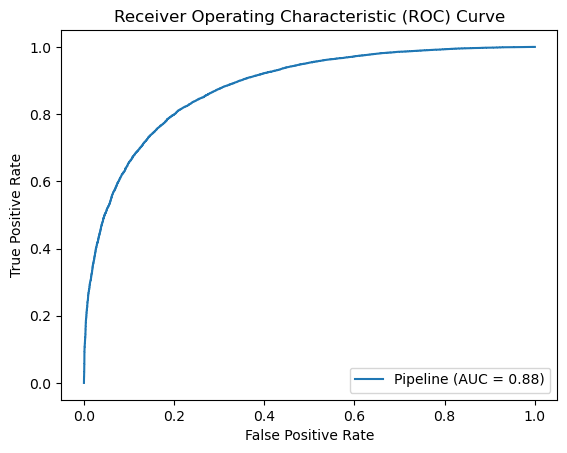

In [45]:
# Plot ROC curve
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_estimator(logreg_pipeline, X_test, y_test)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


In [46]:
# from sklearn.ensemble import RandomForestClassifier
# random_forest_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('random_forest', RandomForestClassifier())  # Use RandomForestClassifier
# ])

# random_forest_pipeline.fit(X_train, y_train)
# accuracy = random_forest_pipeline.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")


In [47]:
# from sklearn.neighbors import KNeighborsClassifier

# knn_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('knn', KNeighborsClassifier())  # Use KNeighborsClassifier
# ])

# knn_pipeline.fit(X_train, y_train)
# accuracy = knn_pipeline.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")


In [48]:
# svm_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('svm', SVC())  # Use SVC (Support Vector Machine) classifier
# ])

# svm_pipeline.fit(X_train, y_train)
# accuracy = svm_pipeline.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")


# CART

In [49]:
# from sklearn.tree import DecisionTreeClassifier


# decision_tree_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('decision_tree', DecisionTreeClassifier())  # Use DecisionTreeClassifier
# ])

# decision_tree_pipeline.fit(X_train, y_train)
# accuracy = decision_tree_pipeline.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")


In [50]:
X_test.columns

Index(['reviewText', 'rating', 'genre', 'ratingContents', 'audienceScore',
       'distributor', 'boxOffice', 'releaseDateStreaming',
       'releaseDateTheaters', 'director', 'soundType', 'runtimeMinutes',
       'originalLanguage'],
      dtype='object')

In [51]:
# from lightgbm import LGBMClassifier

# lgbm_pipe = Pipeline([
#     ('preprocessor', preprocessor),
#     ('skb', skb),
#     ('lgbm', LGBMClassifier(num_leaves=1000,max_depth=1000,n_jobs=-1,verbose=3,force_col_wise=True))
# ])
# lgbm_pipe.fit(X_train,y_train)
# lgbm_pipe.fit(X_test,y_test)


# # Perform cross-validation
# cv_scores = cross_val_score(lgbm_pipe, X_train, y_train, cv=5, scoring='accuracy')
# cv_scores
# cv_scores.mean()

In [52]:
param_grid = {
#     'k_percentile__percentile': [10, 20, 30, 40, 50],
#     'logreg__C': [0.1, 1, 10, 100, 1000],
#     'logreg__penalty': ['l2'],
#     'logreg__solver': ['liblinear', 'lbfgs', 'sag', 'saga', 'newton-cg'],
    'logreg__max_iter': [1000],
#     'k_percentile__percentile': [10],
    'logreg__C': [ 1],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['liblinear'],
}



In [53]:
grid_search_lr = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose = 3
)

# Fit the grid search to the training data
grid_search_lr.fit(X_train, y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('reviewText',
                                                                         Pipeline(steps=[('text_processor',
                                                                                          TextProcessor()),
                                                                                         ('tfidf_vectorizer',
                                                                                          TfidfVectorizer(stop_words='english'))]),
                                                                         'reviewText'),
                                                                        ('genre',
                                                                         Pipeline(steps=[('text_processor',
                                                                                          TextProcessor()),
                                                                                         ('count',
                                                                                          CountVectorizer())]),
                                                                         'genre'),
                                                                        ('ratingContents',
                                                                         P...
                                                                          'director',
                                                                          'distributor',
                                                                          'releaseDateTheaters',
                                                                          'releaseDateStreaming',
                                                                          'soundType',
                                                                          'originalLanguage'])])),
                                       ('k_percentile',
                                        SelectPercentile(percentile=25)),
                                       ('logreg',
                                        LogisticRegression(max_iter=100000))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1], 'logreg__max_iter': [1000],
                         'logreg__penalty': ['l2'],
                         'logreg__solver': ['liblinear']},
             scoring='accuracy', verbose=3)

In [54]:
# Print the best parameters and best score
print("Best parameters:", grid_search_lr.best_params_)
print("Best score:", grid_search_lr.best_score_)

Best parameters: {'logreg__C': 1, 'logreg__max_iter': 1000, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best score: 0.8151667133310901


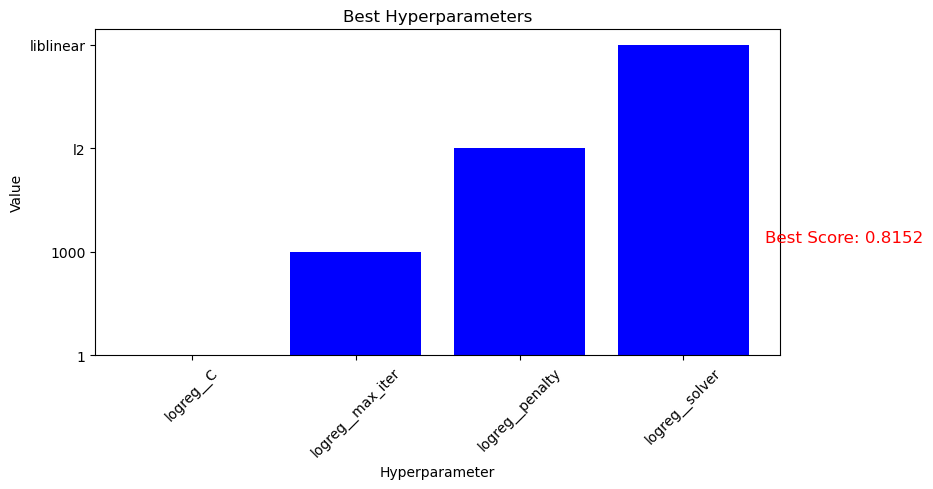

In [55]:
import matplotlib.pyplot as plt

best_params = {'logreg__C': 1, 'logreg__max_iter': 1000, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
best_score = 0.8151667133310901

# Convert numeric values to strings
best_params_str = {key: str(value) for key, value in best_params.items()}

plt.figure(figsize=(8, 5))

# Visualize best parameters
plt.bar(best_params_str.keys(), best_params_str.values(), color='blue')
plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.title('Best Hyperparameters')
plt.xticks(rotation=45)
plt.tight_layout()

# Add text annotation for the best score
plt.text(3.5, 1.1, f'Best Score: {best_score:.4f}', fontsize=12, color='red')

plt.show()


In [56]:
scores = grid_search_lr.cv_results_
scores = pd.DataFrame(scores)
scores


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__max_iter,param_logreg__penalty,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,16.498027,1.814751,2.05858,0.253742,1,1000,l2,liblinear,"{'logreg__C': 1, 'logreg__max_iter': 1000, 'lo...",0.814163,0.81525,0.816458,0.816893,0.813069,0.815167,0.001419,1


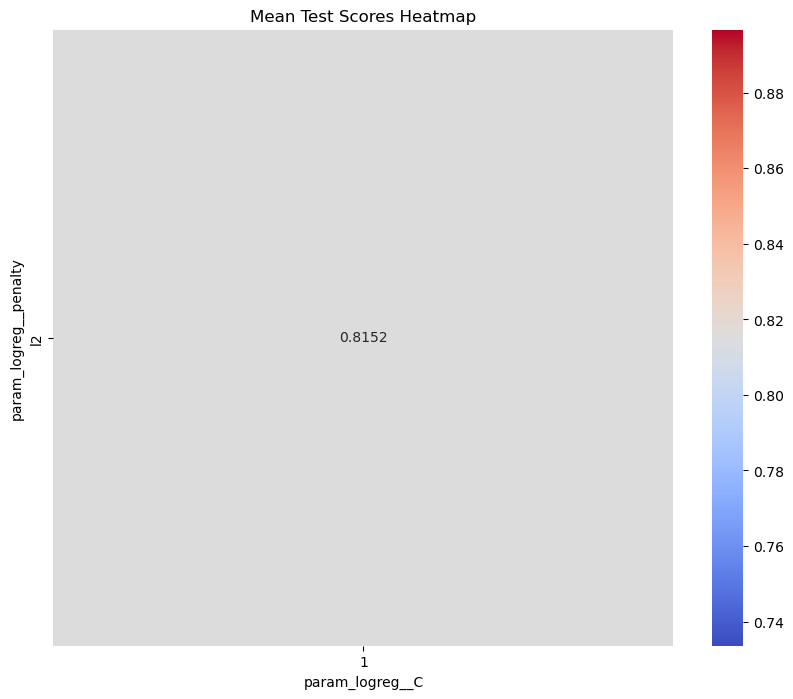

In [57]:
# Define the hyperparameter columns
hyperparam_columns = ['param_logreg__C', 'param_logreg__max_iter', 'param_logreg__penalty', 'param_logreg__solver']

# Pivot the DataFrame to create a heatmap
pivot_df = scores.pivot_table(index=hyperparam_columns, values='mean_test_score', aggfunc='mean')

# Reset the index for visualization
pivot_df = pivot_df.reset_index()

# Create a pivot table for the heatmap
heatmap_data = pivot_df.pivot(index='param_logreg__penalty', columns='param_logreg__C', values='mean_test_score')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Mean Test Scores Heatmap')
plt.xlabel('param_logreg__C')
plt.ylabel('param_logreg__penalty')
plt.show()

In [58]:
# Assuming you've completed your grid search and obtained the best estimator
best_estimator = grid_search_lr.best_estimator_

In [59]:
# Make predictions using the best estimator on the processed test data
predictions = best_estimator.predict(test_df)

In [60]:
predictions.shape

(55315,)

In [61]:
# Step 7: Generate predictions for the test data and create submission file

sentiment_mapping = {0: 'NEGATIVE', 1: 'POSITIVE'}
submission_df = pd.DataFrame(columns=['id', 'sentiment'])

submission_df['id'] = [i for i in range(len(predictions))]
submission_df['sentiment'] = [i for i in predictions ]
submission_df['sentiment'] = submission_df['sentiment'].map(sentiment_mapping)

submission_df.to_csv("submission.csv", index=False)
